In [ ]:
"""
Maxwell Zheng 1004907871
Google Colab Link: https://colab.research.google.com/drive/1O5zbI6t0Y0V1gxqC7mPnuyKQzT0gpoUv?usp=sharing
"""

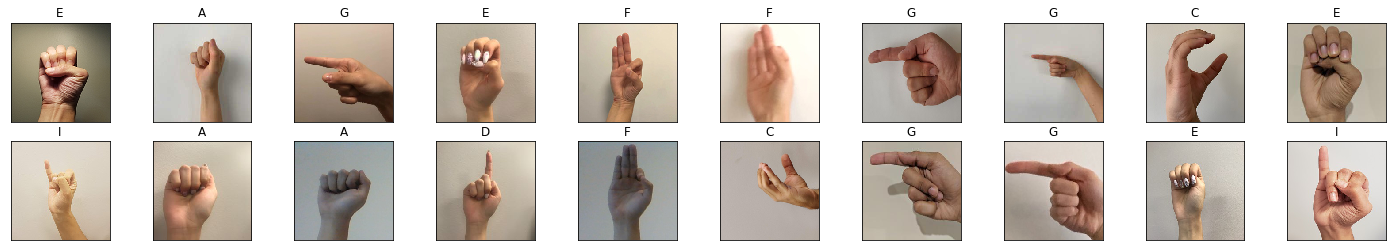

In [29]:
# 1

import torch
import numpy as np
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler

# Images saved locally (Google Drive not working)
masterPath = "C:\\Users\\Maxwell\\Documents\\Code\\Python\\APS360\\src\\Labs\\Lab3\\Images\\"

#Transform Settings
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

#Splits Data Sets
trainData = torchvision.datasets.ImageFolder(masterPath+"Train", transform=transform)
valData = torchvision.datasets.ImageFolder(masterPath+"Val", transform=transform)
testData = torchvision.datasets.ImageFolder(masterPath+"Test", transform=transform)

"""
Data was split so that ~60% of it is training, ~20% is validation, and ~%20 is testData
Sample code is shown below to indicate how I managed to automatically organize this data
"""

#Prepare Dataloader
trainSize = len(trainData)
batchSize = 32
numWorkers = 1

trainLoader = torch.utils.data.DataLoader(trainData, batch_size=batchSize, num_workers=numWorkers, shuffle=True)
valLoader = torch.utils.data.DataLoader(valData, batch_size=batchSize, num_workers=numWorkers, shuffle=True)
testLoader = torch.utils.data.DataLoader(testData, batch_size=batchSize, num_workers=numWorkers, shuffle=True)

#Verification
dataIter = iter(trainLoader)
images, labels = dataIter.next()
images = images.numpy()

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

#Visualize
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(letters[labels[idx]])




In [ ]:
"""
Sample code of how I organized my images in training, validation, and testing data sets


import os
import math
import shutil

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

path = "C:\\Users\\Maxwell\\Documents\\Code\\Python\\APS360\\src\\Labs\\Lab3\\Images"

for letter in letters:


    trainPath = path+"\\Train\\"+letter
    testPath = path+"\\Test\\"+letter
    valPath = path+"\\Val\\"+letter

    os.mkdir(trainPath)
    os.mkdir(valPath)
    os.mkdir(testPath)

    imgsPath = path+"\\Raw\\"+letter
    imgs = os.listdir(imgsPath)

    dirSize = len(imgs)
    trainSize = math.floor(dirSize*.6)
    valSize = math.floor(dirSize*0.2)
    testSize = math.ceil(dirSize*0.2)
    
    for i in range(dirSize):

        imgPath = imgsPath+"\\"+imgs[i]
        
        if i in range(trainSize):

            shutil.copy(imgPath, trainPath+"\\"+imgs[i])

        elif i in range(trainSize,trainSize+testSize):

            shutil.copy(imgPath, testPath+"\\"+imgs[i])

        elif i in range(trainSize+testSize,trainSize+testSize+valSize):

            shutil.copy(imgPath, valPath+"\\"+imgs[i])

"""

In [43]:
# Helper Functions

from typing import Callable, Tuple, List


def getModelName(name: str, batchSize: int, learningRate: float, epoch: int) -> str:
    
    """
    Generates the name of the model using the given hyperparamters values
    
    Parameters
    ---------
        name: str
            name of the model
        batchSize: int
            size of the training batch
        learningRate: float
            rate at which the model learns
        epoch:
            the specific training epoch that is exepected
    
    Returns
    =======
        str:
            the name of the model
    """
    
    
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batchSize, learningRate, epoch)
    
    return path


def normalizeLabels(labels: torch.Tensor) -> torch.Tensor:
    
    """
    Normalize a tensor to 0 or 1
    
    Parameters
    ----------
    labels: torch.Tensor()
        1D tensor with two scalar values
    
    Returns
    =======
    torch.Tensor()
        tensor normalized to 0 or 1
    
    """
    
    maxVal = torch.max(labels)
    minVal = torch.min(labels)
    normLabels = (labels-minVal)/(maxVal-minVal)
    
    return normLabels


def evaluate(net: torch.nn, loader: torch.utils.data.DataLoader, criterion: Callable) -> Tuple[float]:
    
    """
    Evaluates the network with the validation data set
    
    Paramters
    ---------
    net: torch.nn
        PyTorch neural net
    loader: torch.utils.data.DataLoader
        PyTorch data loader for validation data set
    criterion:
        callable loss function
        
    Returns
    =======
    tuple[float]:
        tuple of the average classifcation error and loss function over the validation data set
    
    """
    totalLoss = 0.0
    totalErr = 0.0
    totalEpoch = 0
    
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalizeLabels(labels)
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs>0.0).squeeze().long() != labels
        
        totalErr += int(corr.sum())
        totalLoss += loss.item()
        totalEpoch += len(labels)
    
    err = float(totalErr)/totalEpoch
    loss = float(totalLoss)/(i+1)
    
    return err, loss


def getRelevantIndices(dataset: torchvision.datasets.ImageFolder, classes: List[str], targetClasses: List[str]) -> List[int]:
    
    """
    Returns indices of datapoints from a datset that are part of the target classes
    
    Parameters
    ----------
    dataset: torchvision.datasets.ImageFolder
        PyTorch Dataset
    classes: List[str]
        name of each class
    targetClasses: List[str]
        desired classes
        
    Returns
    =======
    List[int]
        list of indices corresponding to desired classes
    
    """
    
    indices = []
    
    for i in range(len(dataset)):
        labelIndex = dataset[i][1]
        labelClass = classes[labelIndex]
        if labelClass in targetClasses:
            indices.append(i)
            
    return indices


def getDataLoader(targetClasses: List[str], batchSize: int) -> Tuple[torch.utils.data.DataLoader]:
    
    """
    Generates the required data loaders from training, validation, and testing data sets 
    based on the desired target classes
    
    Parameters
    ----------
    targetClasses: List[str]
        list of desired classes
    batchSize: int
        size of the training batch
        
    Returns
    =======
    Tuple[torch.utils.data.DataLoader]
        dataloaders for training, validation, and testing data sets
    """
    
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
    
    relevantTrainIndices = getRelevantIndices(trainData, letters, targetClasses)
    np.random.seed(1000)
    np.random.shuffle(relevantTrainIndices)
    trainSampler = SubsetRandomSampler(relevantTrainIndices)
    trainLoader = torch.utils.data.DataLoader(trainData, sampler=trainSampler, batch_size=batchSize, num_workers=1)
    
    relevantValIndices = getRelevantIndices(valData, letters, targetClasses)
    np.random.shuffle(relevantValIndices)
    valSampler = SubsetRandomSampler(relevantValIndices)
    valLoader = torch.utils.data.DataLoader(valData, sampler=valSampler, batch_size=batchSize, num_workers=1)
    
    relevantTestIndices = getRelevantIndices(testData, letters, targetClasses)
    testSampler = SubsetRandomSampler(relevantTestIndices)
    testLoader = torch.utils.data.DataLoader(testData, sampler=testSampler, batch_size=batchSize, num_workers=1)
    
    return trainLoader, valLoader, testLoader, letters

def plotTrainingCurve(path):
    
    trainErr = np.loadtxt("{}_train_err.csv".format(path))
    valErr = np.loadtxt("{}_val_err.csv".format(path))
    trainLoss = np.loadtxt("{}_train_loss.csv".format(path))
    valLoss = np.loadtxt("{}_val_loss.csv".format(path))
    
    n = len(trainErr)
    
    plt.title("Train vs Validation Error")
    plt.plot(range(1,n+1), trainErr, label="Train")
    plt.plot(range(1,n+1), valErr, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc="best")
    plt.show()
    
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), trainLoss, label="Train")
    plt.plot(range(1,n+1), valLoss, label="validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.show()

In [31]:
# 2a

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import time

torch.manual_seed(1)


class GestureClassifier(nn.Module):
    
    def __init__(self):
        super(GestureClassifier, self).__init__()
        self.name = "net"
        self.conv1 = nn.Conv2d(3, 10, 5, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 26, 5, 2)
        self.fc1 = nn.Linear(26*13*13, 120)
        self.fc2 = nn.Linear(120, 1)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 26*13*13)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        
        return x
        

In [ ]:
"""
I chose to use two convolution layers, two pooling layers, and two linear layers.
Returned one output to not over complicate

Takes 3X244X244 images as input and runs 5x5 kernel with stride=2
After the two convolutional and pooling layers, the result is a 26X13X13 image
This can be easily converted to find the output

10 and 120 were the number of hidden units chosen for the hidden layers.
Made sure not too big to become unmanageable

"""

In [32]:
gestureClassifier = GestureClassifier()

In [37]:
# 2b

def trainNet(net, batchSize, learningRate, numEpochs):
    
    targetClasses = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
    
    torch.manual_seed(1000)
    
    trainLoader, valLoader, testLoader, classes = getDataLoader(targetClasses, batchSize)
    
    criterion = nn.BCEWithLogitsLoss()
    
    optimizer = optim.SGD(net.parameters(), lr=learningRate, momentum=0.9)
    
    trainErr = np.zeros(numEpochs)
    trainLoss= np.zeros(numEpochs)
    valErr = np.zeros(numEpochs)
    valLoss = np.zeros(numEpochs)
    
    startTime = time.time()
    
    for epoch in range(numEpochs):
        totalTrainLoss = 0.0
        totalTrainErr = 0.0
        totalEpoch = 0
        
        for i, data in enumerate(trainLoader, 0):
            inputs, labels = data
            labels = normalizeLabels(labels)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            corr = (outputs>0.0).squeeze().long() != labels
            totalTrainErr += int(corr.sum())
            totalTrainLoss += loss.item()
            totalEpoch += len(labels)
            
        trainErr[epoch] = float(totalTrainErr)/totalEpoch
        trainLoss[epoch] = float(totalTrainLoss)/(i+1)
        valErr[epoch] , valLoss[epoch] = evaluate(net, valLoader, criterion)
        
        print(("Epoch {}: Train err: {}, Train loss: {} | Validation err: {}, Validation loss: {}").format(epoch+1, trainErr[epoch], trainLoss[epoch], valErr[epoch], valLoss[epoch]))
        
        modelPath = getModelName(net.name, batchSize, learningRate, epoch)
        torch.save(net.state_dict(), modelPath)
        
    print("Training Done")
    
    endTime = time.time()
    timeElapsed = endTime - startTime
    print(f"Training time: {timeElapsed:.2f}")
    
    epochs = np.arange(1, numEpochs+1)
    np.savetxt("{}_train_err.csv".format(modelPath), trainErr)
    np.savetxt("{}_train_loss.csv".format(modelPath), trainLoss)
    np.savetxt("{}_val_err.csv".format(modelPath), valErr)
    np.savetxt("{}_val_loss.csv".format(modelPath), valLoss)
            

In [40]:
trainNet(gestureClassifier, batchSize=64, learningRate=0.01, numEpochs=30)

Epoch 1: Train err: 0.10254645560908465, Train loss: 0.33483633658160333 | Validation err: 0.10187110187110188, Validation loss: 0.3309097085148096
Epoch 2: Train err: 0.10254645560908465, Train loss: 0.3372635025045146 | Validation err: 0.11226611226611227, Validation loss: 0.3637523241341114
Epoch 3: Train err: 0.10254645560908465, Train loss: 0.3328200040952019 | Validation err: 0.10187110187110188, Validation loss: 0.32907119020819664
Epoch 4: Train err: 0.10254645560908465, Train loss: 0.32705431010412134 | Validation err: 0.10187110187110188, Validation loss: 0.3256894648075104
Epoch 5: Train err: 0.10254645560908465, Train loss: 0.3218045765938966 | Validation err: 0.10187110187110188, Validation loss: 0.3129476234316826
Epoch 6: Train err: 0.10736407432897453, Train loss: 0.3248104718716248 | Validation err: 0.10187110187110188, Validation loss: 0.2992608081549406
Epoch 7: Train err: 0.10254645560908465, Train loss: 0.3040839330009792 | Validation err: 0.10187110187110188, Vali

Gesture Classifier


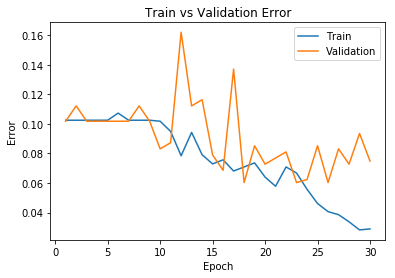

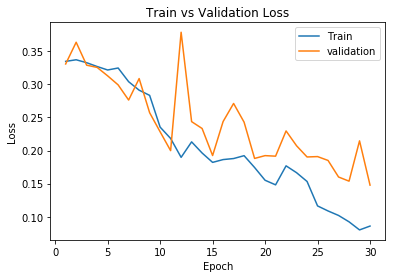

In [44]:
path = getModelName("net", batchSize=64, learningRate=0.01, epoch=29)
print("Gesture Classifier")
plotTrainingCurve(path)

In [49]:
# 2c

path = r"C:\Users\Maxwell\OneDrive\Pictures\Hands"
overfittingData = torchvision.datasets.ImageFolder(path, transform=transform)
trainData = overfittingData
model = GestureClassifier()

trainNet(model, batchSize=27, learningRate=0.005, numEpochs=200)

Epoch 1: Train err: 0.1111111111111111, Train loss: 0.6550501585006714 | Validation err: 0.10187110187110188, Validation loss: 0.6471009784274631
Epoch 2: Train err: 0.1111111111111111, Train loss: 0.6477248072624207 | Validation err: 0.11434511434511435, Validation loss: 0.6350681748655107
Epoch 3: Train err: 0.1111111111111111, Train loss: 0.6338419914245605 | Validation err: 0.10187110187110188, Validation loss: 0.6139561831951141
Epoch 4: Train err: 0.1111111111111111, Train loss: 0.6144905090332031 | Validation err: 0.10602910602910603, Validation loss: 0.5910182562139299
Epoch 5: Train err: 0.1111111111111111, Train loss: 0.590059757232666 | Validation err: 0.10187110187110188, Validation loss: 0.5579033394654592
Epoch 6: Train err: 0.1111111111111111, Train loss: 0.5587219595909119 | Validation err: 0.10602910602910603, Validation loss: 0.5198787351449331
Epoch 7: Train err: 0.1111111111111111, Train loss: 0.5186519026756287 | Validation err: 0.10810810810810811, Validation loss

Epoch 56: Train err: 0.037037037037037035, Train loss: 0.1489049643278122 | Validation err: 0.11434511434511435, Validation loss: 0.3984659082359738
Epoch 57: Train err: 0.037037037037037035, Train loss: 0.13281792402267456 | Validation err: 0.10810810810810811, Validation loss: 0.3915709964931011
Epoch 58: Train err: 0.0, Train loss: 0.11626137048006058 | Validation err: 0.10187110187110188, Validation loss: 0.39489660577641594
Epoch 59: Train err: 0.0, Train loss: 0.10086999088525772 | Validation err: 0.1101871101871102, Validation loss: 0.45433103251788354
Epoch 60: Train err: 0.0, Train loss: 0.08644305169582367 | Validation err: 0.11850311850311851, Validation loss: 0.5302116630805863
Epoch 61: Train err: 0.0, Train loss: 0.07262986153364182 | Validation err: 0.10187110187110188, Validation loss: 0.4633031048708492
Epoch 62: Train err: 0.0, Train loss: 0.05975902080535889 | Validation err: 0.10187110187110188, Validation loss: 0.48263559076521134
Epoch 63: Train err: 0.0, Train lo

Epoch 116: Train err: 0.0, Train loss: 0.00029661355074495077 | Validation err: 0.10602910602910603, Validation loss: 1.3409389439556334
Epoch 117: Train err: 0.0, Train loss: 0.00029315188294276595 | Validation err: 0.11850311850311851, Validation loss: 1.5305079486634996
Epoch 118: Train err: 0.0, Train loss: 0.0002898797392845154 | Validation err: 0.1101871101871102, Validation loss: 1.4058379381895065
Epoch 119: Train err: 0.0, Train loss: 0.0002867573348339647 | Validation err: 0.1101871101871102, Validation loss: 1.3834149407015905
Epoch 120: Train err: 0.0, Train loss: 0.00028378929710015655 | Validation err: 0.11642411642411643, Validation loss: 1.4727064271767933
Epoch 121: Train err: 0.0, Train loss: 0.00028096226742491126 | Validation err: 0.11226611226611227, Validation loss: 1.4705410384469562
Epoch 122: Train err: 0.0, Train loss: 0.00027825869619846344 | Validation err: 0.10187110187110188, Validation loss: 1.2985116988420486
Epoch 123: Train err: 0.0, Train loss: 0.0002

Epoch 176: Train err: 0.0, Train loss: 0.00019790782243944705 | Validation err: 0.10187110187110188, Validation loss: 1.3397541443506877
Epoch 177: Train err: 0.0, Train loss: 0.00019690666522365063 | Validation err: 0.10187110187110188, Validation loss: 1.3402362614870071
Epoch 178: Train err: 0.0, Train loss: 0.0001959275541594252 | Validation err: 0.12058212058212059, Validation loss: 1.604886778526836
Epoch 179: Train err: 0.0, Train loss: 0.00019495727610774338 | Validation err: 0.11226611226611227, Validation loss: 1.496754033697976
Epoch 180: Train err: 0.0, Train loss: 0.00019399139273446053 | Validation err: 0.10810810810810811, Validation loss: 1.454929542210367
Epoch 181: Train err: 0.0, Train loss: 0.00019302555301692337 | Validation err: 0.10187110187110188, Validation loss: 1.3519636856185064
Epoch 182: Train err: 0.0, Train loss: 0.0001920728973345831 | Validation err: 0.10810810810810811, Validation loss: 1.4419389085637198
Epoch 183: Train err: 0.0, Train loss: 0.00019

In [69]:
correct = 0
total = 0
for imgs, labels in torch.utils.data.DataLoader(trainData, batch_size=27):
    output = model(imgs)
    pred = output.max(0, keepdim=True)[1]
    correct += pred.sum().item()
    total += imgs.shape[0]
    
print("Accuracy on batch size of 64: ", correct/total)

Accuracy on batch size of 64:  0.8888888888888888


Gesture Classifier Overfitter


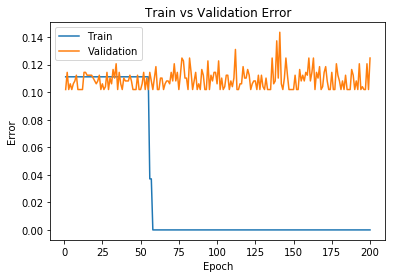

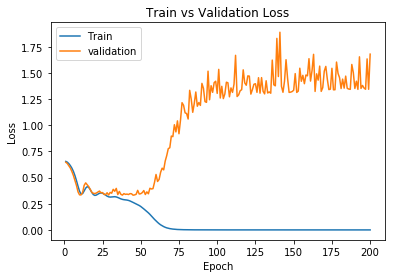

In [50]:
path = getModelName("net", batchSize=27, learningRate=0.005, epoch=199)
print("Gesture Classifier Overfitter")
plotTrainingCurve(path)

In [ ]:
# 3a

"""
Batch size, learning rate and number of epochs are wirth tuning
"""

In [70]:
# 3b

# Testing increase batch size
gestureClassifier = GestureClassifier()
trainNet(gestureClassifier, batchSize=128, learningRate=0.01, numEpochs=30)

Epoch 1: Train err: 0.8888888888888888, Train loss: 0.7192037105560303 | Validation err: 0.10602910602910603, Validation loss: 0.6833260655403137
Epoch 2: Train err: 0.1111111111111111, Train loss: 0.6827201247215271 | Validation err: 0.10187110187110188, Validation loss: 0.6253994107246399
Epoch 3: Train err: 0.1111111111111111, Train loss: 0.6234638094902039 | Validation err: 0.10187110187110188, Validation loss: 0.5526989996433258
Epoch 4: Train err: 0.1111111111111111, Train loss: 0.5507169961929321 | Validation err: 0.10187110187110188, Validation loss: 0.461219422519207
Epoch 5: Train err: 0.1111111111111111, Train loss: 0.45946642756462097 | Validation err: 0.10187110187110188, Validation loss: 0.36789754033088684
Epoch 6: Train err: 0.1111111111111111, Train loss: 0.3720371723175049 | Validation err: 0.10187110187110188, Validation loss: 0.3295661136507988
Epoch 7: Train err: 0.1111111111111111, Train loss: 0.3483225405216217 | Validation err: 0.10187110187110188, Validation lo

Increasing Batch Size


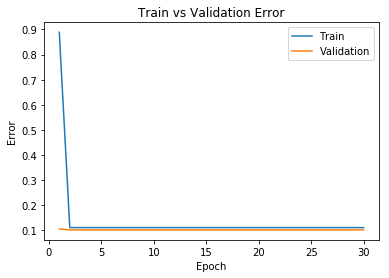

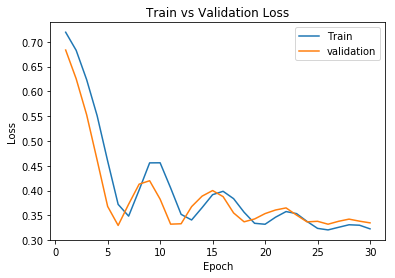

In [71]:
path = getModelName("net", batchSize=128, learningRate=0.01, epoch=29)
print("Increasing Batch Size")
plotTrainingCurve(path)

"""
It seems increasing the batch size does increase the accuracy of the model.
"""

In [72]:
# Testing decrease learning rate
gestureClassifier = GestureClassifier()
trainNet(gestureClassifier, batchSize=64, learningRate=0.001, numEpochs=30)

Epoch 1: Train err: 0.1111111111111111, Train loss: 0.6651840806007385 | Validation err: 0.10187110187110188, Validation loss: 0.6637403070926666
Epoch 2: Train err: 0.1111111111111111, Train loss: 0.6649094820022583 | Validation err: 0.10187110187110188, Validation loss: 0.6627825051546097
Epoch 3: Train err: 0.1111111111111111, Train loss: 0.6643886566162109 | Validation err: 0.10187110187110188, Validation loss: 0.6619185879826546
Epoch 4: Train err: 0.1111111111111111, Train loss: 0.663649320602417 | Validation err: 0.10187110187110188, Validation loss: 0.661278709769249
Epoch 5: Train err: 0.1111111111111111, Train loss: 0.662713348865509 | Validation err: 0.10187110187110188, Validation loss: 0.6597092971205711
Epoch 6: Train err: 0.1111111111111111, Train loss: 0.6616017818450928 | Validation err: 0.10187110187110188, Validation loss: 0.6590870916843414
Epoch 7: Train err: 0.1111111111111111, Train loss: 0.6603335738182068 | Validation err: 0.10187110187110188, Validation loss: 

Decreasing Learning Rate


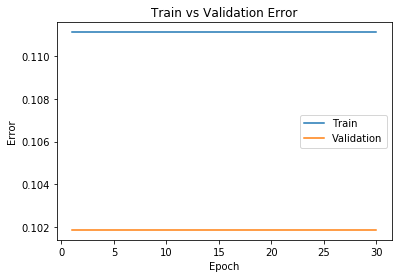

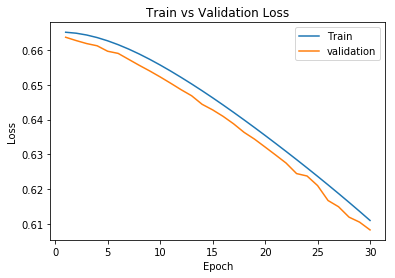

In [73]:
path = getModelName("net", batchSize=64, learningRate=0.001, epoch=29)
print("Decreasing Learning Rate")
plotTrainingCurve(path)

"""
Having a learning rate that is too small does not imporve accuracy
"""

In [ ]:
# 3c

"""
The best model was with batch size=64, learning rate=0.001, and epochs=30
"""

In [79]:
# 3d

trainLoader, valLoader, testLoader, classes = getDataLoader(letters, batchSize=32)
evaluate(gestureClassifier, testLoader, nn.BCEWithLogitsLoss())

"""
Error of 10.8%. Is not ideal, however is not very high either
"""

(0.10816326530612246, 0.6813893094658852)

In [80]:
# 5a

import torchvision.models
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
alexnet = torchvision.models.alexnet(pretrained=True)

In [ ]:
import torchvision.models
import urllib.request

url = r"https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth"
file = "C:\\Users\\Maxwell\\Documents\\Code\\Python\\APS360\\src\\Labs\\Lab3\\.cache\\torch\\checkpoints"
#!del -rf /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth
urllib.request.urlretrieve(url, file)
#!wget https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth -P /root/.cache/torch/checkpoints/
alexnet = torchvision.models.alexnet(pretrained=True)

In [90]:
img = torch.Tensor(1, 3, 244, 244)
print(img)
features = alexnet.features(img)

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.4093, 0.4199, 0.4230],
          [0.4019, 0.3944, 0.3794,  ..., 0.1311, 0.1355, 0.1289],
          [0.1249, 0.1552, 0.1419,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0172, 0.0108, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0623, 0.0810, 0.0806],
          [0.0809, 0.0799, 0.0788,  ..., 0.1818, 0.1446, 0.1705]],

         [[0.1869, 0.1925, 0.1933,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0469, 0.0464, 0.0468],
          [0.0452, 0.0459, 0.0462,  ..., 0.0366, 0.0454, 0.0470],
          ...,
          [0.1696, 0.1756, 0.1775,  ..., 0.0078, 0.0546, 0.0555],
          [0.0544, 0.0538, 0.0410,  ..., 0.4816, 0.4746, 0.4705],
          [0.4610, 0.4595, 0.4532,  ..., 0.1724, 0.1410, 0.1110]],

         [[0.0998, 0.1097, 0.1275,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1860, 0.1768, 0.1734],
          [0.1681, 0.1885, 0.1879,  ..., 0

In [93]:
import os
import torchvision.models

alexnet = torchvision.models.alexnet(pretrained=True)

path = "C:\\Users\\Maxwell\\Documents\\Code\\Python\\APS360\\src\\Labs\\Lab3\\Features"

batchSize = 1
numWorkers = 1
dataset = torchvision.datasets.ImageFolder(masterPath+"Train", transform=transform)
dataLoader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, num_workers=numWorkers, shuffle=True)

letters = classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

n = 0
for img, label in dataLoader:
    features = alexnet.features(img)
    featuresTensor = torch.from_numpy(features.detach().numpy())
    
    folderName = masterPath + str(letters[label])
    if not os.path.isdir(folderName):
        os.mkdir(folderName)
    
    torch.save(featuresTensor.squeeze(0), folderName+"\\" + str(n) + ".tensor")
    n+=1


In [ ]:
path = "C:\\Users\\Maxwell\\Documents\\Code\\Python\\APS360\\src\\Labs\\Lab3\\Features"
trainData = torchvision.datasets.DatasetFolder(path, loader=torch.load, extensions=('.tensor'))

batchSize = 32
numWorkers = 1
featureLoader = torch.utils.data.DataLoader(newData, batch_size=batchSize, num_workers=numWorkers, shuffle=True)

dataIter = iter(featureLoader)
features, labels = dataIter.next()

print(features.shape)
print(labels.shape)

In [ ]:
# 4b

features = alexnet.features(trainData)

In [97]:
class alexNet(nn.Module):
    
    def __init__(self):
        super(alexNet, self).__init__()
        self.name="alex"
        self.conv1 = nn.Conv2d(256, 10, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(10*2*2, 20)
        self.fc2 = nn.Linear(20, 1)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 10*2*2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        
        return x

In [98]:
model = alexNet()
output = model(features)
prob = F.softmax(output)

C:\Users\Maxwell\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# 4c

tensor = torch.from_numpy(tensor.detach().numpy())

